# Численные методы линейной алгебры

In [1]:
import numpy as np
import scipy

import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spla

## Ресурс №1: время

Python стимулирует не писать циклы, а использовать матричные вычисления

## Ресурс №2: память

- параллельные вычисления
- купить GPU покруче
- но если в матрице много нулей - разреженные матрицы

Форматы разреженных матриц:

**Dictionary of Keys (DOK) - словарь (i,j): element**

- быстрое добавление элементов с произвольными индексами
- любые другие операции будут производиться медленно


**List of Lists (LIL) -** матрица хранится построчно: в виде двух массивов $[l_1, \ldots, l_s]$ и $[v_1, \ldots, v_s],$ где $l_i$ - список ноеров столбцов, в которых в $i$-ой строке находится ненулевой элемент, а $v_i$ - список соотвествующих значений.

- добавление за линейное время
- быстрый доступ к строкам матрицы
- может требовать слишком много памяти (для создания матриц повышенной плотности используйте COO)

__Coordinate List (COO)__ - хранятся тройки (row, column, value) или три массива rows, columns, values. При этом тройка с одинаковым началом `(row, column)` может быть не одна; при преобразовании к другому типу значения `value` суммируются.

- быстрое добавление новых элементов
- для всего остального лучше перевести в другой формат 
- не предоставляет произвольного доступа к элементам
- в некоторых случаях может занимать места даже больше, чем обычная (не разреженная) матрица той же размерности.

**Compressed Sparse Row/Column storage (CRS/CSC)** - разберём на примере CSR. Хранятся три массива: `values, indptr` и `indices`. В массиве `values` хранятся все ненулевые элементы матрицы, упорядоченные по индексам лексикографически; 

`indptr[i]` - индекс начала $i-$ой строки, `indices[indptr[i]:indptr[i + 1] - 1]` - номера столбцов соответствующих элементов.

- быстрое выполнение арифметических операций
- быстрый доступ к строкам для CSR и к столбцам для CSC
- очень медленный доступ к столбцам для CSR и к строкам для CSC
- медленное добавление/удаление элементов

Главный вывод - не надо один и тот же формат использовать для разных целей!

- [Больше про разреженные матрицы](https://matteding.github.io/2019/04/25/sparse-matrices/)

У разреженных матриц всё не как у обычных:

| Обычные матрицы               | Разреженные матрицы    |
|:------------------------------|:-----------------------|
| `A + 1`                       | Не определено!         |
| `A * B`                       | `A.multiply(B)`        |
| `A ** 3`                      | `A.power(3)`           |
| `A.dot(B)`                    | `A.dot(B)` или `A*B`   |
| `np.linalg.matrix_power(A, 3)`| `A**3`                 |
| `np.eye(n)`                   | `spla.identity(n)`     |
| `np.zeros((m,n))`             | `sps.???_matrix((m,n))`|

Пример: работа с текстами

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [82]:
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [83]:
X.toarray() # преобразование разреженной матрицы в обычную

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

## Ресурс №3: точность

In [4]:
0.4 - 0.1 == 0.3

False

In [3]:
0.4 - 0.1 

0.30000000000000004

In [6]:
a = 0.4 - 0.1 
np.abs(a - 0.3) < 1e-16

True

Все знают, что: 

- Матрица $A^TA$ всегда неотрицательно определена
- Если $Q$ и $R$ получены из $A$ с помощью ортогонализации Грамма-Шмидта, то $Q$ ортогональная и $A = QR$
- Композиция softmax 

$$
(x_1, \ldots, x_n) \to \left( \frac{e^{x_1}}{\sum_i e^{x_i}}, \ldots,  \frac{e^{x_n}}{\sum_i e^{x_i}} \right)
$$

и кроссэнтропии

$$
(p_1, \ldots, p_n, y_1, \ldots, y_n) \to - \sum_i y_i \ln p_i
$$

всегда определена. 

Но это всё неправда! Любой алгоритм работает с некоторой точностью.

In [28]:
import numpy as np

k = 60
A = np.random.randint(10, size=(k,k))
A_inv = np.linalg.inv(A)

# print(A, '\n')
# print(A_inv, '\n')
# print(np.eye(k), '\n')

print(np.linalg.norm(A @ A_inv - np.eye(k)))

5.949258293181063e-14


In [36]:
n = 20

A = np.random.rand(n, n)
A = A.T @ A # симметричная матрица
L = np.linalg.cholesky(A)

# print(A, '\n')
# print(L, '\n')

np.linalg.norm(L @ L.T - A)

1.067662871904967e-14

In [37]:
import scipy.linalg as splin
P, L, U = splin.lu(A)

np.linalg.norm(P @ L @ U - A)

8.495926837474684e-15

## Пример 1: решение систем

Поэкспериментируем с поиском обратной матрицы.

In [63]:
n = 1000
A = [[1/(i + j + 1) for i in range(n)] for j in range(n)]
A = np.array(A)

# print(A, '\n')
# print(np.linalg.inv(A), '\n')

rhs = np.random.randn(n)    # right hand side
x = np.linalg.solve(A, rhs) # this function compute LU factorization and solves linear system 

In [64]:
#And check if ecerything is fine
er = np.linalg.norm(A.dot(x) - rhs)/np.linalg.norm(rhs)
print(er) # 10^{-12} потеряли 4 знака в точности тк она 10^{-16}

48.11170925152422


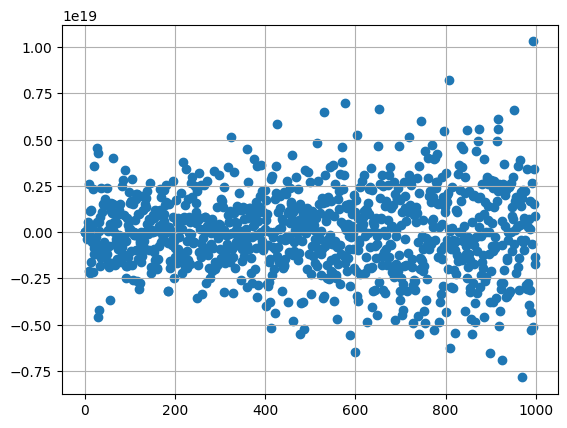

In [65]:
import matplotlib.pyplot as plt

# увеличиваем n в ячейках выше
# тут будет видно что компоненты решения растут по модулю, это сигнал
# что что-то не так и у нас есть проблемы
plt.scatter(list(range(n)), x)
plt.grid(True)

Следует ли из этого, что алгоритм Гаусса будет неустойчивым? Нет. Это свойство матрицы. Какую бы мы не взяли, у нас всегда будет плохое решение. 

## Пример 2: QR-разложение

$$
A = QR
$$

In [75]:
R_0 = np.triu(np.random.randn(50, 50))
Q_0, _ = sla.qr(np.random.randn(50, 50))

A = Q_0 @ R_0

Нужно понимать, что для создателей алгоритма было важно при его реализации. Что миниммизирует numpy? 

а) $||QR - A|| \to \min$

б) $||R - R_0|| \to \min$

в) $||Q - Q_0|| \to \min$

г) $||Q^TQ - I|| \to \min$

In [76]:
Q, R = sla.qr(A)

In [77]:
print(sla.norm(A - Q @ R))

2.1986329687239696e-14


In [78]:
print(sla.norm(R_0 - R))

0.00035753279131478803


In [79]:
print(sla.norm(Q_0 - Q))

0.00030199676864346047


In [80]:
print(sla.norm(Q.T.dot(Q) - np.eye(50)))

4.78699851866098e-15
